In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-06-29 11:59:22.836913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 11:59:22.836938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from FairyTail.data import GetData

In [3]:
X, y = GetData().get()

In [4]:
len(X), len(y)

(65200, 65200)

In [5]:
# let's us a pre-trained word2vec
word2vec = api.load("glove-wiki-gigaword-50")
wv = word2vec

In [6]:
vocab_size = len(wv.key_to_index)
vocab_size

400000

In [7]:
# let's check if all words in y are in word2vec
sum([word in wv for word in y]) / len(y)

1.0

In [8]:
assert(False not in [word in wv for word in y])

In [9]:
# let's check if all words in X are in word2vec
toto = []
for sentence in X:
    for word in sentence:
        toto.append(word)
sum([word in wv for word in toto]) / len(toto)

0.9932706685785074

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed and pad the training and test sentences
X_train_pad = pad_sequences(embedding(word2vec, X_train), dtype='float32', padding='post', maxlen=20)
X_test_pad = pad_sequences(embedding(word2vec, X_test), dtype='float32', padding='post', maxlen=20)

In [12]:
# check the shape of the padded data
X_train_pad.shape, X_test_pad.shape

((45640, 20, 50), (19560, 20, 50))

In [13]:
# transform y_train and y_test into vectors
y_train_vec = np.array([wv[word] for word in y_train])
y_test_vec = np.array([wv[word] for word in y_test])

In [14]:
# check the shape of the target data
y_train_vec.shape, y_test_vec.shape

((45640, 50), (19560, 50))

In [15]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(GRU(50, activation="tanh", return_sequences=True))
    model.add(GRU(16, activation="tanh", return_sequences=False))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(50, activation="linear"))

    model.compile(loss='mae',
                  optimizer='rmsprop',
                  metrics=['mse'])
    
    return model

model = init_model()

2022-06-29 11:59:53.354385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 11:59:53.354405: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 11:59:53.354422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (think): /proc/driver/nvidia/version does not exist
2022-06-29 11:59:53.354657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train_vec, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100
1997/1997 [==============================] - 47s 19ms/step - loss: 0.3458 - mse: 0.2137 - val_loss: 0.3399 - val_mse: 0.2050
Epoch 2/100
1997/1997 [==============================] - 41s 20ms/step - loss: 0.3391 - mse: 0.2035 - val_loss: 0.3371 - val_mse: 0.2011
Epoch 3/100
1997/1997 [==============================] - 38s 19ms/step - loss: 0.3373 - mse: 0.2015 - val_loss: 0.3377 - val_mse: 0.2020
Epoch 4/100
1997/1997 [==============================] - 35s 18ms/step - loss: 0.3361 - mse: 0.2001 - val_loss: 0.3360 - val_mse: 0.2000
Epoch 5/100
1997/1997 [==============================] - 36s 18ms/step - loss: 0.3348 - mse: 0.1988 - val_loss: 0.3350 - val_mse: 0.1987
Epoch 6/100
1997/1997 [==============================] - 35s 18ms/step - loss: 0.3336 - mse: 0.1976 - val_loss: 0.3346 - val_mse: 0.1974
Epoch 7/100
1997/1997 [==============================] - 36s 18ms/step - loss: 0.3323 - mse: 0.1962 - val_loss: 0.3367 - val_mse: 0.1997
Epoch 8/100
1997/1997 [==================

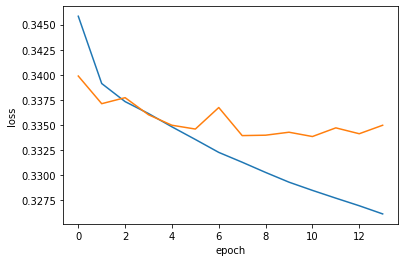

In [17]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"]
})
sns.lineplot(data=history_df, x="epoch", y="loss");
sns.lineplot(data=history_df, x="epoch", y="val_loss");

In [18]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(SimpleRNN(50, activation="tanh", return_sequences=True))
    model.add(SimpleRNN(16, activation="tanh", return_sequences=False))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(50, activation="linear"))

    model.compile(loss='mae',
                  optimizer='rmsprop',
                  metrics=['mse'])
    
    return model

model = init_model()

In [19]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train_vec, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100
1997/1997 [==============================] - 26s 12ms/step - loss: 0.3509 - mse: 0.2258 - val_loss: 0.3406 - val_mse: 0.2043
Epoch 2/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3410 - mse: 0.2056 - val_loss: 0.3407 - val_mse: 0.2057
Epoch 3/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3402 - mse: 0.2046 - val_loss: 0.3396 - val_mse: 0.2031
Epoch 4/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3390 - mse: 0.2034 - val_loss: 0.3392 - val_mse: 0.2026
Epoch 5/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3379 - mse: 0.2022 - val_loss: 0.3375 - val_mse: 0.2015
Epoch 6/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3370 - mse: 0.2012 - val_loss: 0.3374 - val_mse: 0.2010
Epoch 7/100
1997/1997 [==============================] - 22s 11ms/step - loss: 0.3363 - mse: 0.2004 - val_loss: 0.3369 - val_mse: 0.2003
Epoch 8/100
1997/1997 [==================

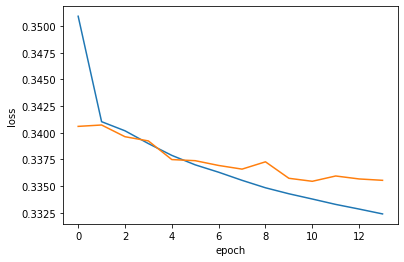

In [20]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"]
})
sns.lineplot(data=history_df, x="epoch", y="loss");
sns.lineplot(data=history_df, x="epoch", y="val_loss");

In [21]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(SimpleRNN(50, activation="tanh", return_sequences=True))
    model.add(SimpleRNN(16, activation="tanh", return_sequences=False))
    model.add(Dense(50, activation="linear"))

    model.compile(loss='mae',
                  optimizer='rmsprop',
                  metrics=['mse'])
    
    return model

model = init_model()

In [22]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train_vec, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100
1997/1997 [==============================] - 32s 15ms/step - loss: 0.3470 - mse: 0.2154 - val_loss: 0.3404 - val_mse: 0.2046
Epoch 2/100
1997/1997 [==============================] - 29s 14ms/step - loss: 0.3408 - mse: 0.2056 - val_loss: 0.3391 - val_mse: 0.2046
Epoch 3/100
1997/1997 [==============================] - 27s 14ms/step - loss: 0.3394 - mse: 0.2041 - val_loss: 0.3386 - val_mse: 0.2027
Epoch 4/100
1997/1997 [==============================] - 24s 12ms/step - loss: 0.3386 - mse: 0.2030 - val_loss: 0.3388 - val_mse: 0.2026
Epoch 5/100
1997/1997 [==============================] - 25s 12ms/step - loss: 0.3379 - mse: 0.2022 - val_loss: 0.3375 - val_mse: 0.2014
Epoch 6/100
1997/1997 [==============================] - 25s 12ms/step - loss: 0.3372 - mse: 0.2015 - val_loss: 0.3379 - val_mse: 0.2027
Epoch 7/100
1997/1997 [==============================] - 24s 12ms/step - loss: 0.3366 - mse: 0.2008 - val_loss: 0.3378 - val_mse: 0.2009
Epoch 8/100
1997/1997 [==================

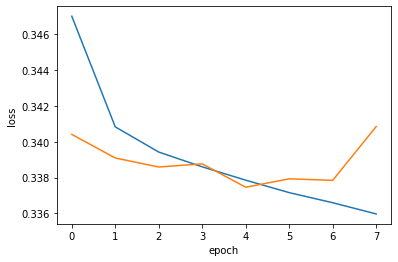

In [23]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"]
})
sns.lineplot(data=history_df, x="epoch", y="loss");
sns.lineplot(data=history_df, x="epoch", y="val_loss");